non-spiking input data -> spikes

In [1]:
import torch
import snntorch as snn

In [2]:
batch_size = 128
data_path = '/tmp/data/mnist'
num_classes = 10 # MNIST의 ouput클래스 수

dtype = torch.float

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((28,28)), # 이미지 shape=(28,28)
    transforms.Grayscale(), # 흑백으로. channel=1
    transforms.ToTensor(), # numpy -> tensor. 정수 -> 실수
    transforms.Normalize((0,), (1,))
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.19MB/s]


In [ ]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")
# training set 60000 -> 6000

The size of mnist_train is 6000


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

time-varying dataset으로 만들기  
1. 같은 sample을 매 시간마다 전달
2. 입력을 spike train 열로 변환 후 한번에 전달(이걸로 쓸게)


## spike encoding
1. rate coding  
2. latency coding  
3. delta modulation

### rate coding
얼마나 많이 spike  
$X_{ij}$ -> $R_{ij}$ ~Bernoulli(n,p)  
$P(R_{ij}=1)=X_{ij}=1-P(R_ij=0)$


In [ ]:
num_steps = 10

raw_vector = torch.ones(num_steps)*0.5 # 요소가 0.5인 크기 10 텐서 만듦. 0.5=스파이크 발생 확률

rate_coded_vector = torch.bernoulli(raw_vector) # 요소가 0또는 1로
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

# num_steps high => 확률이 원래 요소와 비슷해져?

Converted vector: tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
The output is spiking 40.00% of the time.


In [ ]:
from snntorch import spikegen

data = iter(train_loader)
data_it, targets_it = next(data) # (batch_size, 1, 28, 28)

spike_data = spikegen.rate(data_it, num_steps=num_steps) # (num_steps, batch_size, 1, 28, 28) => 실수값을 0,1로

In [ ]:
print(spike_data.size()) # (10개 시간 단계, 128장 이미지, 흑백, 28*28 크기)

torch.Size([10, 128, 1, 28, 28])


In [ ]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [ ]:
spike_data_sample = spike_data[:,0,0] # (시간은 다 가져와, 첫번째 이미지, 첫번재 채널)
print(spike_data_sample.size())

torch.Size([10, 28, 28])


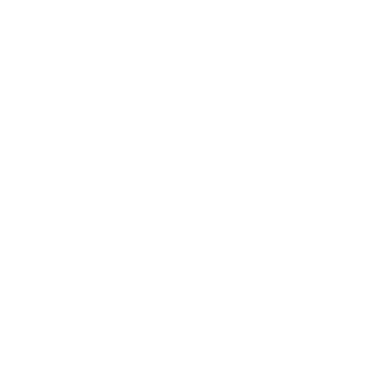

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

In [ ]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 9


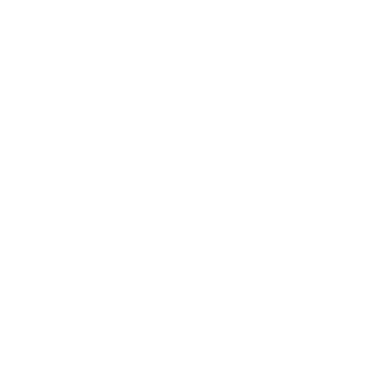

In [ ]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:,0,0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

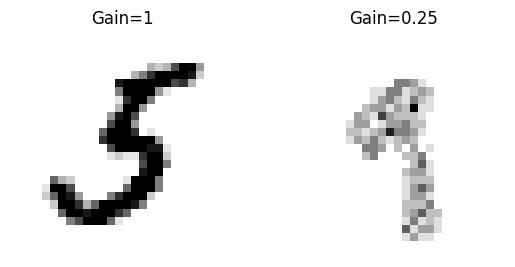

In [ ]:
plt.figure(facecolor='w')
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary') # time 축에 평균내기
plt.axis('off')
plt.title('Gain=1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain=0.25')

plt.show()

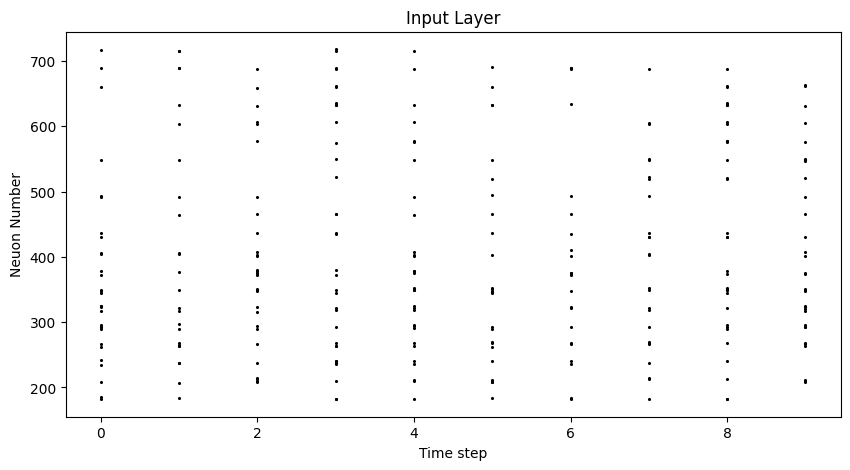

In [ ]:
# raster plot : 시간에 따른 뉴런의 스파이크 발생 기록
## 밝은 픽셀에 해당하는 뉴런 인덱스에 점이 빽빽하게
## 세로축으로 모여있으면 강한 자극. 가로축으로 모여있으면 그 뉴런이 활발한 활동
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

fig = plt.figure(facecolor='w', figsize=(10,5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c='black')

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuon Number")
plt.show()

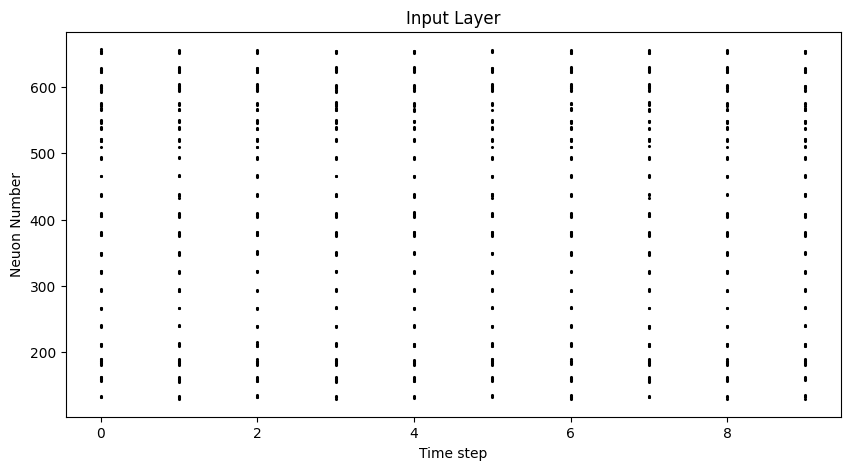

In [ ]:
spike_data_sample = spike_data_sample.reshape((num_steps, -1))

fig = plt.figure(facecolor='w', figsize=(10,5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample, ax, s=1.5, c='black')

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuon Number")
plt.show()

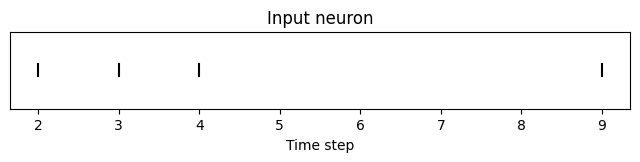

In [ ]:
# 210번째 뉴런
idx = 210

fig = plt.figure(facecolor='w', figsize=(8,1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample2.reshape(num_steps, -1)[:,idx].unsqueeze(1), ax, s=100, c='black', marker='|')
# [10,28,28]-> [10,784] => 모든 시간의 210번째 뉴런 => [10]->[10,1]
plt.title("Input neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## latency coding
얼마나 빨리 spike
big input : fast spike  
small input : late spike

In [ ]:
# RC 회로 수식
def convert_to_time(data, tau=5, threshold=0.01): # tau : 상수
  spike_time = tau*torch.log(data/(data-threshold))
  return spike_time

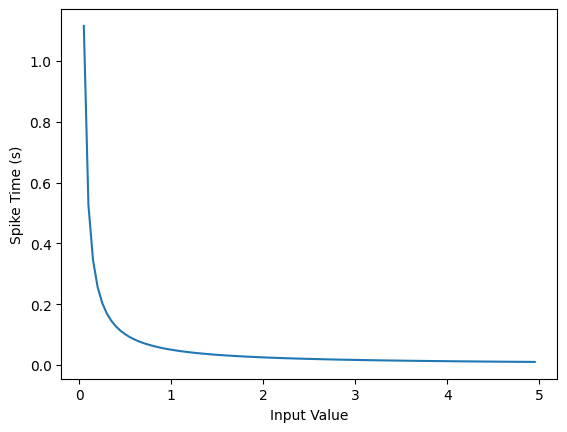

In [ ]:
raw_input = torch.arange(0, 5, 0.05)
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel("Input Value")
plt.ylabel("Spike Time (s)")
plt.show()
# 픽셀의 밝기가 클수록 spike time이 적게 걸린다

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

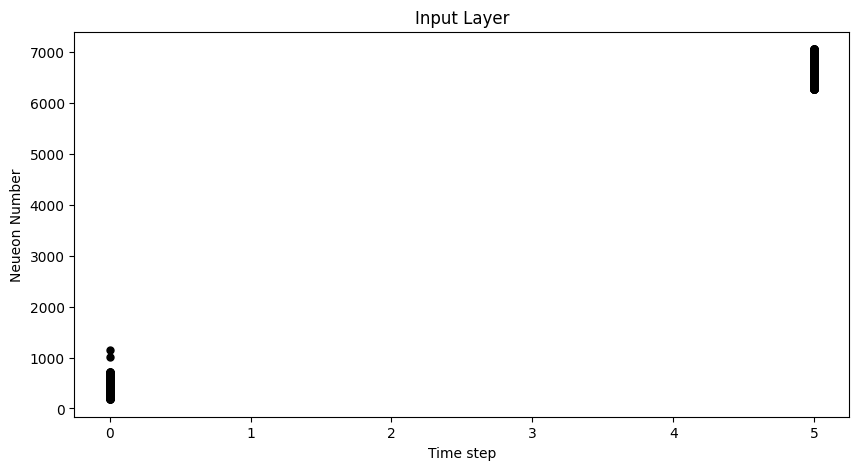

In [ ]:
fig = plt.figure(facecolor='w', figsize=(10,5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:,0].reshape(num_steps, -1), ax, s=25, c='black')

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neueon Number")
plt.show()
# 검은색 부분의 뉴런은 찍히지 않아
# 색이 밝을수록(강도가 세다) 먼저 찍

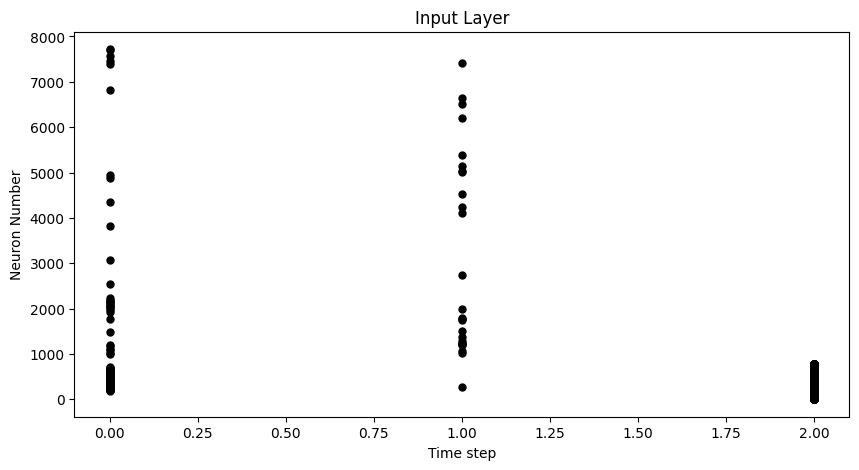

In [ ]:
# linear=True : 스파이크 시간을 선형
spike_data = spikegen.latency(data_it, num_steps=100, tau=20, threshold=0.01, linear=True)

fig = plt.figure(facecolor='w', figsize=(10,5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:,0].reshape(num_steps, -1), ax, s=25, c='black')
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

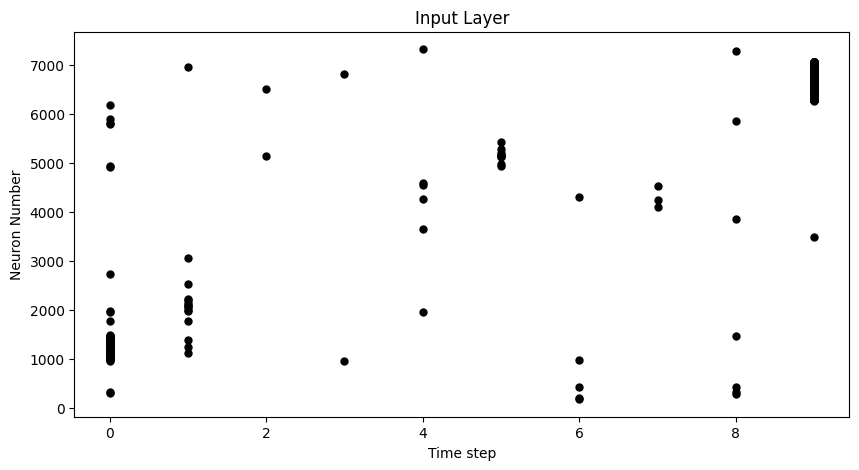

In [ ]:
# normalize=True : 스파이크 시간을 num_steps 안에 맞춰
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].reshape(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

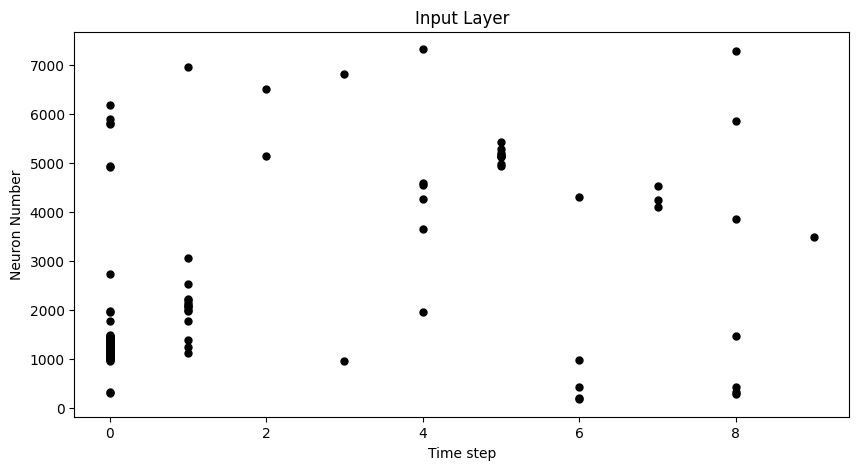

In [ ]:
# clip=True : num_steps를 벗어나는 스파이크를 시간에 맞춤. 예외처리(정산범위에 있는 애들은 바꾸지 않아)
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].reshape(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [ ]:
spike_data_sample = spike_data[:,0,0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


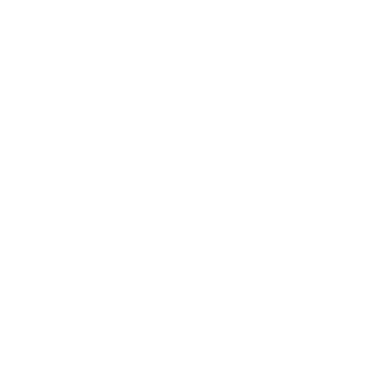

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

In [ ]:
print(targets_it[0])

tensor(9)


### delta modulation
전과 후의 차이가 양수일때만 spike  
뉴런은 변화가 양수이고 임계값보다 클때만 활성화되는 특성에 기반

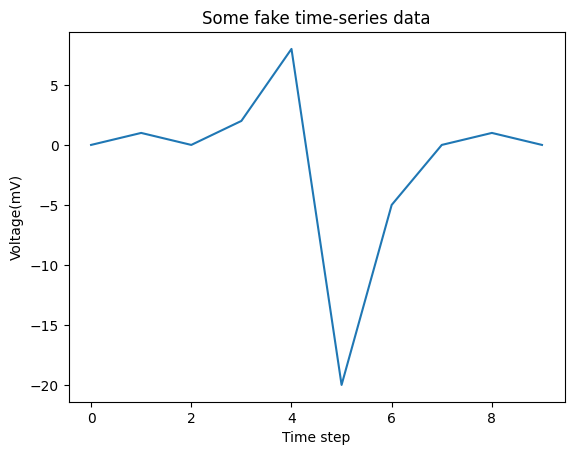

In [ ]:
data = torch.Tensor([0, 1, 0, 2, 8, -20, -5, 0, 1, 0])

plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage(mV)")
plt.show()

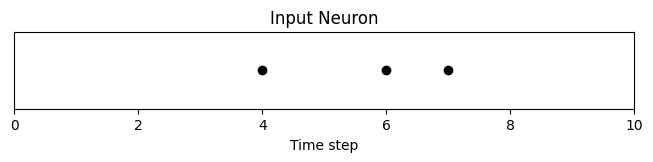

In [ ]:
# data[T+1]-data[T] > threshold => spike
spike_data = spikegen.delta(data, threshold=4)

fig = plt.figure(facecolor='w', figsize=(8,1))
ax = fig.add_subplot(111)

splt.raster(spike_data, ax, c='black')

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

In [ ]:
print(spike_data)

tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0.])


### spike generation

In [ ]:
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype)*0.5
spike_rand = spikegen.rate_conv(spike_prob)

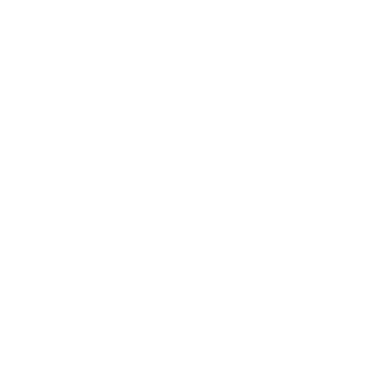

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

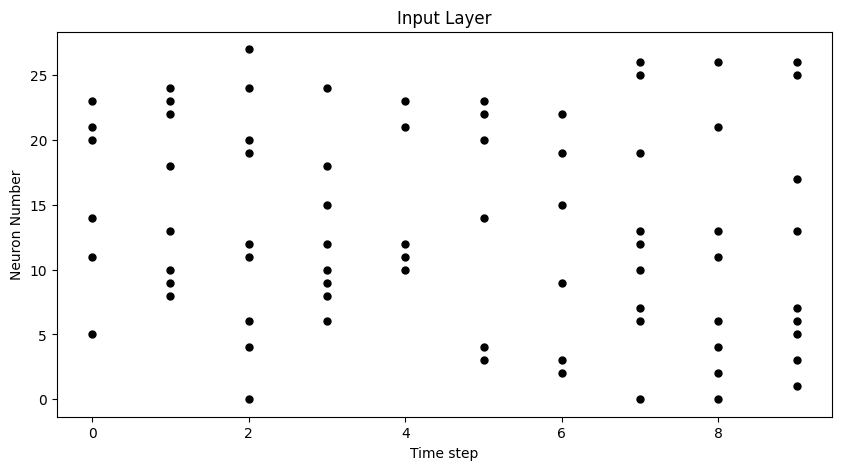

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()